10 epoch loss 0.11270495
20 epoch loss 0.06736776
30 epoch loss 0.044080824
40 epoch loss 0.024693675
50 epoch loss 0.008619525
60 epoch loss 0.005255189
70 epoch loss 0.0044868453
80 epoch loss 0.0035161374
90 epoch loss 0.0031563754


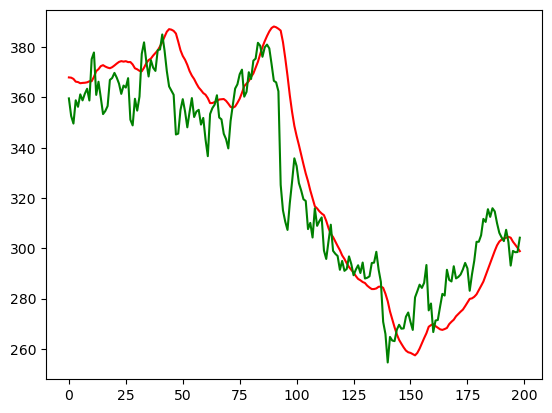

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Load the dataset (assuming it contains a 'Close' column)
df = pd.read_csv(r"C:\Users\Anshu\Desktop\NFLX.csv")
closed_prices = df["Close"]

# Set the sequence length and initialize MinMaxScaler
seq_len = 15
mm = MinMaxScaler()

# Normalize the closing prices
scaled_price = mm.fit_transform(np.array(closed_prices)[..., None]).squeeze()

# Prepare input sequences (X) and corresponding output (y)
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[..., None]
y = np.array(y)[..., None]

# Split the data into training and testing sets
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

# Define the LSTM model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        return self.fc(hidden[-1, :])

# Instantiate the model with input size 1 and hidden size 64
model = Model(1, 64)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output, train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if epoch % 10 == 0 and epoch != 0:
        print(epoch, "epoch loss", loss.detach().numpy())

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    output = model(test_x)

# Inverse transform the predictions and actual values
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

# Plot the predicted and real values
plt.plot(pred.squeeze(), color="red", label="predicted")
plt.plot(real.squeeze(), color="green", label="real")
plt.show()
